In [13]:
library(dplyr)
library(ggplot2)
library(repr)
library(tidyr)
library(Matrix)
library(Seurat)
library(dorothea)
library(dplyr)
library(Seurat)
library(tibble)
library(pheatmap)
library(tidyr)
library(viper)
library(reshape2)
library(forcats)
library(ggpubr)
library(cowplot)

options(repr.plot.width=50, repr.plot.height=10)

In [14]:
setwd('/home/jovyan/data/covid_nasal/datasets')
covid<-readRDS("covid_integrated.RDS")

In [475]:
## We read Dorothea Regulons for Human:
dorothea_regulon_human <- get(data("dorothea_hs", package = "dorothea"))

## We obtain the regulons based on interactions with confidence level A, B and C
regulon <- dorothea_regulon_human %>%
    dplyr::filter(confidence %in% c("A","B","C"))



In [4]:
Idents(covid)<-'Treatment'
covid_S<-subset(covid, id = 'Pos')

In [5]:
DefaultAssay(covid_S)<-'RNA'
covid_S <- covid_S %>% 
NormalizeData() %>%
FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>%
ScaleData()

Centering and scaling data matrix



In [6]:
## We compute Viper Scores 
covid_S <- run_viper(covid_S, regulon,
                  options = list(method = "scale", minsize = 4, 
                                 eset.filter = FALSE, cores = 1, 
                                 verbose = FALSE))

In [7]:
DefaultAssay(covid_S)<-'dorothea'

covid_S <- ScaleData(covid_S)

viper_scores_df <- GetAssayData(covid_S, slot = "scale.data", 
                                    assay = "dorothea") %>%
  data.frame(check.names = F) %>%
  t()

Centering and scaling data matrix



In [8]:
## We create a data frame containing the cells and their clusters
Idents(covid_S)<-'initial_clustering'

CellsClusters <- data.frame(cell = names(Idents(covid_S)), 
                            cell_type = as.character(Idents(covid_S)),
                            check.names = F)



In [55]:
DefaultAssay(covid_S)<-'RNA'
a<-FetchData(covid_S, vars = "covid--N")
temp<-rep(FetchData(covid_S, vars = "covid--N")$`covid--N`, 271)
viper_scores_clusters$`covid--N`<-temp
temp_group<-by(viper_scores_clusters, viper_scores_clusters$tf, FUN = function(X) cor(X$activity, X$`covid--N`, method = "spearman"))
temp_group<-data.frame(group = dimnames(temp_group)[[1]], corr = as.vector(temp_group))

In [9]:
## We create a data frame with the Viper score per cell and its clusters
viper_scores_clusters <- viper_scores_df  %>%
  data.frame() %>% 
  rownames_to_column("cell") %>%
  gather(tf, activity, -cell) %>%
  inner_join(CellsClusters)


Joining, by = "cell"



In [10]:
## We summarize the Viper scores by cellpopulation
summarized_viper_scores <- viper_scores_clusters %>% 
  group_by(tf, cell_type) %>%
  summarise(avg = mean(activity),
            std = sd(activity))

`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.



In [37]:
highly_variable_tfs <- summarized_viper_scores %>%
  group_by(tf) %>%
  mutate(var = var(avg))  %>%
  ungroup() %>%
  top_n(800, var) %>%
  distinct(tf)

## We prepare the data for the plot
summarized_viper_scores_df <- summarized_viper_scores %>%
  semi_join(highly_variable_tfs, by = "tf") %>%
  dplyr::select(-std) %>%   
  spread(tf, avg) %>%
  data.frame(row.names = 1, check.names = FALSE) 

In [337]:
summarized_viper_scores_df_subset<-summarized_viper_scores_df %>% select(matches('REL|NFKB|IRF|STAT'))

In [40]:
summarized_viper_scores_df_subset$cell = rownames(summarized_viper_scores_df_subset)

In [41]:
summarized_viper_scores_df_subset<-melt(summarized_viper_scores_df_subset, id = 'cell')

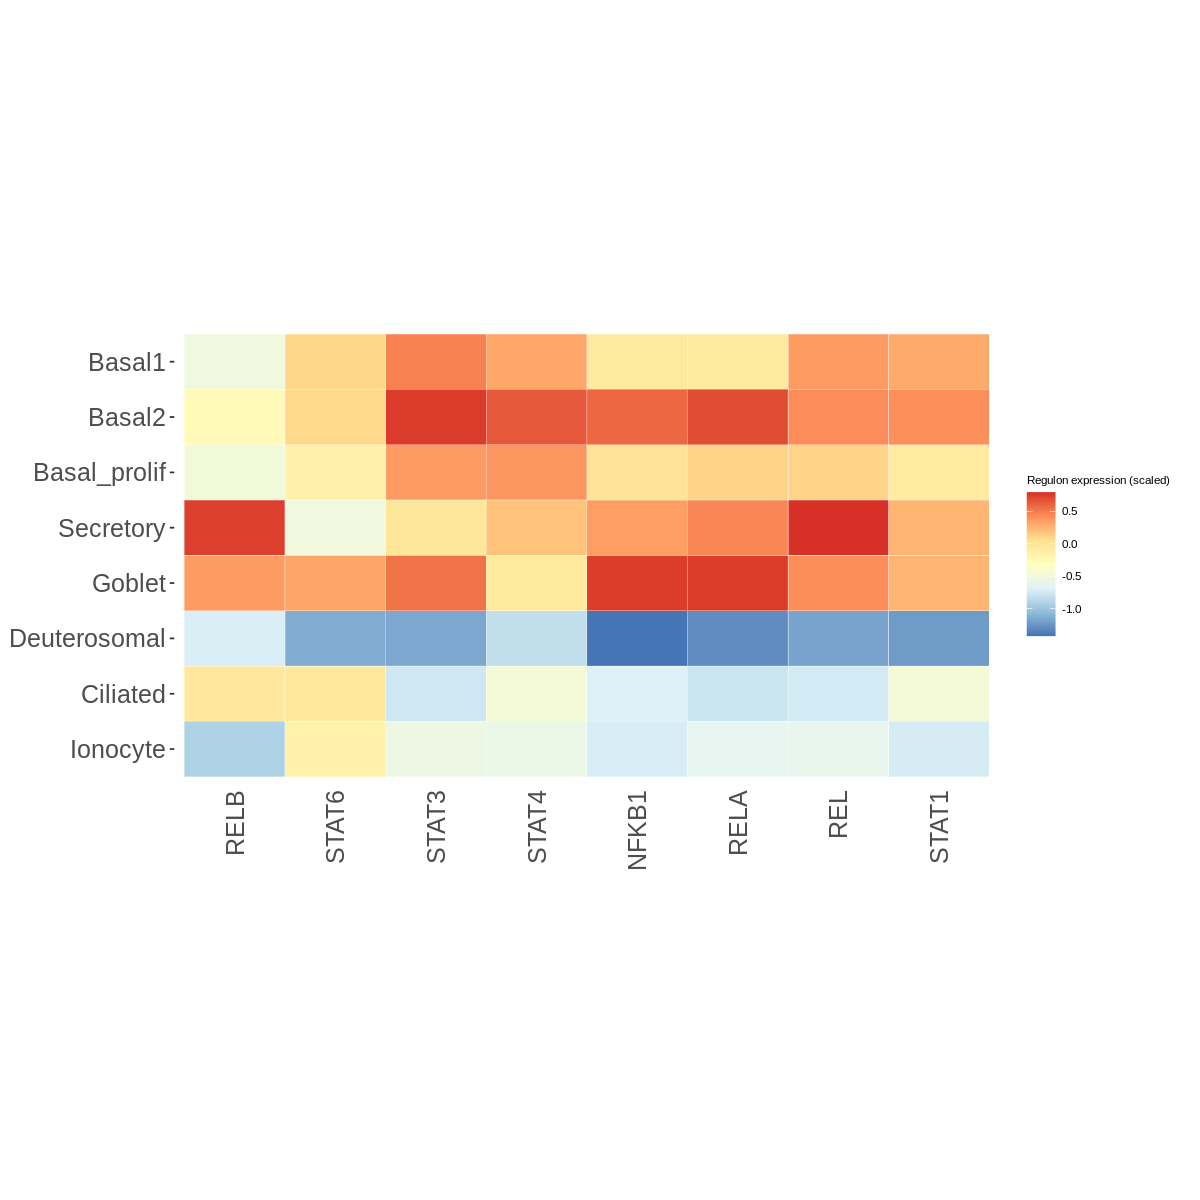

In [47]:
options(repr.plot.width=10, repr.plot.height=10)

summarized_viper_scores_df_subset$cell <- factor(summarized_viper_scores_df_subset$cell,
                                                 levels = rev(c("Basal1",
                                                                "Basal2",
                                                                "Basal_prolif",
                                                                "Secretory",
                                                                "Goblet",
                                                                "Deuterosomal",
                                                                "Ciliated",
                                                                "Ionocyte")))

summarized_viper_scores_df_subset$variable <- factor(summarized_viper_scores_df_subset$variable,
                                                 levels = c("RELB",
                                                               'STAT6',
                                                               'STAT3',
                                                               'STAT4',
                                                               'NFKB1',
                                                               'RELA',
                                                               'REL',
                                                               'STAT1'))

ggplot(summarized_viper_scores_df_subset, aes(cell, variable, fill= value)) + 
   geom_tile(color = "white")+

 scale_fill_distiller(palette = 'RdYlBu', direction = -1) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
coord_flip() + theme(aspect.ratio = 0.55) +
  theme(axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        axis.ticks.x=element_blank(),
       axis.text=element_text(size=15),
       legend.text = element_text(size = 7), 
        legend.title = element_text(size = 7))+
labs(fill='Regulon expression (scaled)')+ theme(panel.background = element_blank())



***Correct for regulon activity in negative cells***



In [ ]:
setwd('/home/jovyan/data/covid_nasal/datasets')
covid<-readRDS("covid_integrated.RDS")

In [3]:
##Create a new identity class based on whether cell is infected
uninfected <- subset(x = covid, 
                     subset = `covid--ORF1ab` == 0 &
                     `covid--S` == 0 &
                     `covid--ORF3a` == 0 &
                     `covid--E` == 0 &
                     `covid--M` == 0 &
                     `covid--ORF6` == 0 &
                     `covid--ORF7a` == 0 &
                     `covid--ORF8` == 0 &
                     `covid--N` == 0 &
                     `covid--ORF10` == 0
                     , slot='counts')

infected_cells<-setdiff(colnames(covid), colnames(uninfected))

Idents(object = covid, cells = Cells(uninfected)) <- 'uninfected'
Idents(object = covid, cells = infected_cells) <- 'infected'

covid[["infection"]] <- Idents(covid)

In [4]:
covid@meta.data$combined<-paste0(covid@meta.data$Treatment, '_', covid@meta.data$infection)

In [6]:
Idents(covid)<-'combined'
temp<-subset(covid, id = c('Pos_infected'))

In [5]:
temp<-covid@meta.data %>% select('Treatment', 'initial_clustering', 'infection')

In [6]:
## We read Dorothea Regulons for Human:
dorothea_regulon_human <- get(data("dorothea_hs", package = "dorothea"))

## We obtain the regulons based on interactions with confidence level A, B and C
regulon <- dorothea_regulon_human %>%
    dplyr::filter(confidence %in% c("A","B","C"))



In [7]:
DefaultAssay(covid)<-'RNA'
covid <- covid %>% 
NormalizeData() %>%
FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>%
ScaleData()

Centering and scaling data matrix



In [ ]:
## We compute Viper Scores 
covid <- run_viper(covid, regulon,
                  options = list(method = "scale", minsize = 4, 
                                 eset.filter = FALSE, cores = 1, 
                                 verbose = FALSE))

In [ ]:
DefaultAssay(covid)<-'dorothea'

covid <- ScaleData(covid)

viper_scores_df <- GetAssayData(covid, slot = "scale.data", 
                                    assay = "dorothea") %>%
  data.frame(check.names = F) %>%
  t()

In [ ]:
viper_scores_df <- GetAssayData(covid, slot = "scale.data", 
                                    assay = "dorothea") %>%
  data.frame(check.names = F) %>%
  t()

In [ ]:
auc_mtx<-merge(viper_scores_df, temp, by=0, all=TRUE)
rownames(auc_mtx)<-auc_mtx$Row.names
auc_mtx$Row.names<-NULL

In [ ]:
auc_mtx<-a

In [ ]:
#Only keep untreated cells and infected positive cells

auc_mtx<-auc_mtx %>% filter(Treatment == 'Neg' & infection == 'uninfected'| Treatment == 'Pos' & infection == 'infected')

In [ ]:
pos<-auc_mtx %>% 
select(-infection) %>%
group_by(Treatment, initial_clustering) %>% 
summarise_all(median) %>% 
ungroup() %>%
filter(Treatment == "Neg") %>%
select(-Treatment)

neg<-auc_mtx %>% 
select(-infection) %>%
group_by(Treatment, initial_clustering) %>% 
summarise_all(median) %>% 
ungroup() %>%
filter(Treatment == "Pos") %>%
select(-Treatment)


In [ ]:
pos<-melt(pos)
colnames(pos)<-c('initial_clustering', 'regulon', 'pos')
neg<-melt(neg)
colnames(neg)<-c('initial_clustering', 'regulon', 'neg')

In [ ]:
neg$pos<-pos$pos
corrected_regulon <- transform(neg, corrected = pos - (neg))
corrected_regulon <- corrected_regulon %>% filter(grepl("STAT|IRF|JAK|NFK|REL|initial", regulon))
corrected_regulon <- corrected_regulon %>% select(initial_clustering, regulon, corrected)

corrected_regulon<-dcast(corrected_regulon, initial_clustering ~ regulon)

In [ ]:
rownames(corrected_regulon)<-corrected_regulon$initial_clustering
corrected_regulon$initial_clustering<-NULL

In [ ]:
corrected_regulon$celltype<-rownames(corrected_regulon)
corrected_regulon<-melt(corrected_regulon, id = 'celltype')
colnames(corrected_regulon)<-c('celltype', 'regulon', 'value')

In [ ]:
corrected_regulon$celltype <- factor(corrected_regulon$celltype, levels = rev(c("Basal1", "Basal2", "Basal_prolif", "Goblet",
                                                             "Secretory", "Ciliated",
                                                             "Deuterosomal", "Ionocyte")))

options(repr.plot.width=10, repr.plot.height=10)

ggplot(corrected_regulon, aes(celltype, regulon, fill= value)) + 
   geom_tile(color = "white")+

 scale_fill_distiller(palette = 'RdYlBu', direction = -1) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
coord_flip() + theme(aspect.ratio = 0.55) +
  theme(axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        axis.ticks.x=element_blank(),
       axis.text=element_text(size=15),
       legend.text = element_text(size = 7), 
        legend.title = element_text(size = 7))+
labs(fill='Regulon expression (scaled)')+ theme(panel.background = element_blank())

setwd('/home/jovyan/data/covid_nasal/figures')
ggsave("covid_nasal_dorothea_neg_vs_pos.png", plot = last_plot(), device = NULL, path = NULL,width = 10, height = 10,  scale = 1)